# Previous Preparations
## Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
import sys
from pathlib import Path
import scipy.io as sio

sys.path.append('../..');
from function.learning.model_Had_DCAN import *
from function.learning.nets import *
from function.misc.disp import *
from function.misc.metrics import *



import tabulate
import os, sys
import warnings

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Defining functions to load the experimental Data

In [2]:
def read_mat_data_index(expe_data, nflip, lambda_i = 548):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    lambda_indices = np.where(np.abs(F_spectro-lambda_i)<1);
    num_channel = lambda_indices[0][0];
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_pos = F_data_pos[:,:,num_channel];
    F_neg = F_data_neg[:,:,num_channel];
    if (2**16-1 in F_pos) or (2**16-1 in F_neg):
        warnings.warn("Warning, Saturation!", UserWarning)
    F_pos = F_pos.astype("int64");
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;


def read_mat_data(expe_data, nflip, lambda_min = 460, lambda_max = 700):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F_pos = F_data_pos[:,:,F_spectro>lambda_min];
    F_neg = F_data_neg[:,:,F_spectro>lambda_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F_pos = F_pos[:,:,F_spectro<lambda_max];
    F_neg = F_neg[:,:,F_spectro<lambda_max];
    F_pos = np.sum(F_pos, axis=2);
    F_pos = F_pos.astype("int64");
    F_neg = np.sum(F_neg, axis=2);
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;

def read_mat_data_proc(expe_data, nflipi, lamda_min=460, lambda_max = 700):
    F = sio.loadmat(expe_data+"_{}_100_data.mat".format(nflip));
    F_data = F["F_WT_lambda"];
    F_spectro = F["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F = F_data[:,:,F_spectro>lamdba_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F = F[:,:,F_spectro<lambda_max];
    F = np.sum(F , axis=2);
    return F;

def load_data_list_index(expe_data,nflip, CR, K, Perm, img_size, num_channel = 548):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        F_pos = F_pos;
        F_neg = F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list

def load_data_list(expe_data,nflip, CR, K, Perm, img_size, lambda_min = 460, lambda_max = 700):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        F_pos = 1/K*F_pos;
        F_neg = 1/K*F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list
  
def ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def raw_ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        gt_list.append(Gt);
    return gt_list


def ground_truth_list(expe_data,nflip, H, img_size, lambda_min = 460, lambda_max = 700):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, denoise, H, suffix, model_root):
    net_type = ['c0mp', 'comp','pinv', 'free']
    list_nets = [];
    for N0 in N0_list:
        recon_type = "";
        if N0==0:
            train_type = ''
        else :
            train_type = '_N0_{:g}_sig_{:g}'.format(N0,sig)
            if denoise:
                recon_type+="_Denoi";
        #- training parameters
        title = model_root + 'NET_'+net_type[net_arch]+train_type+recon_type+suffix ;
        if N0==0:
            model = compNet(img_size, CR, Mean_had, Cov_had, net_arch, H)
        else:
            if denoise:
                model = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
            else:
                model = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
        model = model.to(device);
        load_net(title,model);
        list_nets.append(model);
    return list_nets;

def simulated_noisy_images(gt_list, max_list, K, H):
    gt_index = max_list.index(max(max_list));
    GT = gt_list[gt_index];
    N = GT.shape[0];
    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = N*H[H>0];
    H_neg[H<0] = -N*H[H<0];
    simu_list = [];
    for i in range(len(gt_list)):
        if i!=gt_index:
            f_noi = simulated_measurement(GT, max_list[i]/K, H_pos, H_neg, N, H)
        else:
            f_noi = GT;
        simu_list.append(f_noi)
    return simu_list


def simulated_measurement(GT, N0, H_pos, H_neg, N, H):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m_pos = np.dot(H_pos,f);
    m_neg = np.dot(H_neg,f);
    m_pos += np.multiply(np.sqrt(m_pos),np.random.normal(0,1,size = m_pos.shape));
    m_neg += np.multiply(np.sqrt(m_neg),np.random.normal(0,1,size = m_neg.shape));
    m_noi = m_pos-m_neg;
    f_noi = np.reshape((1/N)*np.dot(H, m_pos-m_neg), (N, N));
    f_noi = 2*(f_noi-np.amin(f_noi))/(np.amax(f_noi)-np.amin(f_noi))-1;
    return f_noi;


def normalize(Img, a, b):
    return (a-b)*(Img-np.amin(Img))/(np.amax(Img)-np.amin(Img))+b;



def batch_flipud(vid):
    outs = vid;
    for i in range(vid.shape[1]):
        outs[0,i,0,:,:] = np.flipud(vid[0,i,0,:,:]);
    return outs;

## Defining functions to improve the metrics

In [3]:
def double_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    f_mean = np.mean(f_vec);
    g_mean = np.mean(g_vec);
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f - N*f_mean*g_mean)/(g_norm-g_mean**2);
    b = (f_mean*g_norm - g_mean*g_f)/(g_norm-g_mean**2);
    return a*g+b;


def single_param_reg(f,g):
    N = f.shape[-2]*f.shape[-1];
    f_vec = np.reshape(f[0,0,:,:], (N,1));
    g_vec = np.reshape(g[0,0,:,:], (N,1));
    g_norm = np.dot(np.transpose(g_vec), g_vec);
    g_f = np.dot(np.transpose(g_vec), f_vec);
    a = (g_f)/(g_norm);
    return a*g;

In [4]:
from scipy.sparse.linalg import aslinearoperator
import pylops

#mu = 1.5
def TV(y, H, img_size, mu = 0.15, lamda = [0.1, 0.1], niter = 20, niterinner = 10):
    ny = img_size;
    nx = img_size;
    A = aslinearoperator(H);
    H_p = pylops.LinearOperator(A)
    Dop = \
        [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                                kind='backward', dtype=np.float64),
         pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                                kind='backward', dtype=np.float64)]
    xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H_p, Dop, y.flatten(),
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
    return xinv;

In [5]:
from bm3d import bm3d, BM3DProfile


def diag(y):
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;


def Denoi_stat_comp(y, Sigma, Sigma_a, H):
    Pat = np.dot(Sigma, np.transpose(H));
    P_k = np.linalg.inv(Sigma_a+np.dot(H,Pat));
    P_k = np.dot(Pat, P_k);
    x_k = np.dot(P_k,y);
    P_k = Sigma + np.dot(P_k, np.transpose(Pat));
    return x_k, P_k

def BM3D_tikho(x_noi, P_k):
    sigma = np.mean(Diag(P_k));
    x_est = bm3d(x_noi, sigma);
    return x_est;

def BM3D_tikho_from_meas_expe(m, CR, img_size, H_k, Cov_had, Perm, H, g, C, s):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    
    y_k_pos = m[even_index];
    y_k_neg = m[odd_index];
    Sigma_a = 1/g*(y_k_pos+y_k_neg)- 2*C/g +2*s**2/g**2;
    One = np.dot(H_k, np.ones((img_size**2,)));
    y_k = 1/g*(y_k_pos-y_k_neg);
    alpha_est = np.amax(np.dot(np.dot(np.transpose(H_k), np.linalg.inv(np.dot(H_k, np.transpose(H_k)))),y_k))
    Sigma_a = Sigma_a/(alpha_est**2);
    y_k = 2/alpha_est*y_k - One;
    Sigma_a = diag(Sigma_a);
    
    Sigma = img_size**2*np.dot(Perm,np.dot(Cov_had,np.transpose(Perm)));
    Sigma_i = 1/img_size**2*np.dot(np.transpose(H),np.dot(Cov_had,H))
    x_k_est, P_k = Denoi_stat_comp(y_k, Sigma_i, Sigma_a, H_k);
    x_k_est = np.reshape(x_k_est, (img_size, img_size))
    x_k_bm3d = BM3D_tikho(x_k_est, P_k);
    return x_k_bm3d;
    


## Parameters
### Acquisition Parameters

In [6]:
img_size = 64; # Height / width dimension
sig =0.5; # std maximum total number of photons
K =1.6; # Normalisation constant
C = 1070;
s = 55;

### Network and training

In [7]:
data_root = "../../data/", # Path to SLT-10 dataset
net_arch = 0;   # Network architecture (variants for the FCL)
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute =  False # Tells if the precomputed data is available 
model_root = '../../models/SDCAN/'; #  Path to model saving files

### Experimental data

In [8]:
expe_root = "../../data/expe_2/" # Path to precomputed data

### Optimisation

In [9]:
num_epochs = 100 ; #Number of training epochs 
batch_size = 256 ; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 10; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate

## Loading Preprocessed Data

In [10]:
my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
H = sio.loadmat(my_transform_file);
H = (1/img_size)*H["H"]
#H_2 = Hadamard_Transform_Matrix(opt.img_size);


my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)


my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')

print('Loading covariance and mean')
Mean_had_1 = sio.loadmat(my_average_file)
Cov_had_1  = sio.loadmat(my_cov_file)


# Normalisation of imported Mean and Covariance.

Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
Cov_had_1 = Cov_had_1["C"];
Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
     
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)


Loading covariance and mean
Loading covariance and mean


# Compressed Reconstruction via CNN (CR = 7/8)

## Parameters

In [11]:
CR = 512; # Number of patterns
even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);


# Var = Cov2Var(Cov_had)
# Perm = Permutation_Matrix(Var)
Pmat = np.dot(Perm,H);
H_k = Pmat[:CR,:];


## Loading Relevant Neural Networks

In [13]:

suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
        img_size, CR, num_epochs, lr, step_size,\
        gamma, batch_size, reg)

# N0_list = [700, 150, 80, 60, 30, 10, 10];
# N0_list_OG = [500, 150, 80, 60, 30, 10, 2];
N0_list = [2500];
# with HiddenPrints():
model_list = net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, 0, H, suffix, model_root);
model_list_denoi = net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, 1, H, suffix, model_root);
model_list_no_noise = net_list(img_size, CR, Mean_had, Cov_had,net_arch, [0 for i in range(len(N0_list))], sig, 1, H, suffix,model_root);

model = noiCompNet(img_size, CR, Mean_had, Cov_had, 3, 50, 0.5, H)
root_model = '../../models/OE/NET_free_N0_2500_sig_0.5_N_64_M_512_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07'
load_net(root_model,model);
model = model.to(device)

titles = ["GT",  "TV", "Tikhonov","Noiseless Net", "Free Layer", "Tikhonov+bm3d", "Proposed"]

# titles = ["GT", "PI",  "TV", "Tikhonov","Noiseless Net", "Free Layer", "Tikhonov+bm3d", "Proposed"]


Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Model Loaded: ../../models/SDCAN/NET_c0mp_N0_2500_sig_0.5_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Denoised Measurements
Model Loaded: ../../models/SDCAN/NET_c0mp_N0_2500_sig_0.5_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
Model Loaded: ../../models/SDCAN/NET_c0mp_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: free
Varying N0 = 50 +/- 25
Model Loaded: ../../models/OE/NET_free_N0_2500_sig_0.5_N_64_M_512_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


## LED Lamp - Part 3
### Loading the Compressed Data

In [14]:
titles_expe = ["noObjectD_1_0.0_variance", "noObjectD_1_0.3_02_variance"]+\
              ["noObjectD_1_0.3_03_variance", "noObjectD_1_0.3_04_variance"]+\
              ["noObjectD_1_0.3_01_variance"]+\
              ["noObjectD_1_0.3_01_variance", "noObjectD_1_0.6_variance"]+\
              ["noObjectD_1_1.0_variance", "noObjectD_1_1.3_variance"]

channel = 548;

nflip = [1 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);


m_prim = [];
m_prim.append(sum(m_list[:4])+m_list[6]);
m_prim.append(sum(m_list[:2]));
m_prim.append(m_list[0]);
m_prim.append(m_list[6]+m_list[8]);
m_prim = m_prim+m_list[7:];
m_list = m_prim;

<ipython-input-2-20ace512ca7b>:13: UserWarning: Warning, Saturation!
  warnings.warn("Warning, Saturation!", UserWarning)


### Loading Ground Truth
We normalize the incoming data, so that it has the right functioning range for neural networks to work with.

In [15]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:4])+GT[6]);
GT_prim.append(sum(GT[:2]));
GT_prim.append(GT[0]);
GT_prim.append(GT[6]+GT[8]);
GT_prim = GT_prim+GT[7:];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];


<ipython-input-2-20ace512ca7b>:13: UserWarning: Warning, Saturation!
  warnings.warn("Warning, Saturation!", UserWarning)


### Displaying the results
Once all the networks have been loaded, we appy those networks on the loaded Compressed Data.

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

from time import perf_counter
title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

with torch.no_grad():
    for i in range(len(GT)):
        list_outs = [];
        x_Pinv = model_list[0].forward_N0_Pinv(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Stat_comp = model_list[0].forward_N0_maptoimage(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Denoi_Stat_comp = model_list_denoi[0].forward_N0_maptoimage_expe(m_list[i]*4, 1, 1, img_size, img_size, C, s, K);

        t1_start = perf_counter() 
        x_SDCAN = model_list_no_noise[0].forward_postprocess(x_Stat_comp, 1,1, img_size, img_size);
        t1_stop = perf_counter() 
        print("CNN time = {}s".format(t1_stop-t1_start))
        
        x_SDCAN_denoi = model_list_denoi[0].forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);
        x_free = model.forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);
        
        
#         print(x_bm3d.shape)
        
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(H_k), np.linalg.inv(np.dot(H_k, np.transpose(H_k)))),m))
        x_tv = 2*TV(m/alpha_est, H_k, img_size)-1;
#         x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),1/alpha_est**2*(1/K*np.mean(torch2numpy(m_list[i][0,0,even_index]+m_list[i][0,0,uneven_index]))- 2*C/K +2*s**2/K**2))
        
        t1_start = perf_counter() 
        x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),0.3)
        t1_stop = perf_counter() 
        print("BM3D time = {}s".format(t1_stop-t1_start))
#         x_bm3d = BM3D_tikho_from_meas_expe(torch2numpy(m_list[i][0,0,:]), CR, img_size, H_k, Cov_had, Perm, H, K, C, s)

#         print(np.amax(x_tv))
#         print(np.amin(x_tv))

        x_bm3d = torch.Tensor(x_bm3d).to(device);
        x_bm3d = x_bm3d.view(1,1, img_size, img_size);
        x_tv = torch.Tensor(x_tv).to(device);
        x_tv = x_tv.view(1,1, img_size, img_size);
        
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
#         list_outs.append(x_Pinv);
        list_outs.append(x_tv);
        list_outs.append(x_Denoi_Stat_comp);
        list_outs.append(x_SDCAN);
        list_outs.append(x_free);
        list_outs.append(x_bm3d);
        list_outs.append(x_SDCAN_denoi);
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
#         ssim = batch_ssim_vid(Ground_truth, output);
        outputs.append(torch2numpy(output));
#         title_lists.append(["{} {},\n PSNR = {},\n SSIM = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2),round( ssim[j],2)) for j in range(len(titles))]);
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);
    



CNN time = 0.003055826999116107s
BM3D time = 0.2838301190004131s
CNN time = 0.0003607319995353464s


../../function/misc/metrics.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  Psnr=10*np.log(d**2/MSE)/np.log(10);


BM3D time = 0.24341301300046325s
CNN time = 0.0003780309998546727s
BM3D time = 0.26064946099904773s
CNN time = 0.0004211650011711754s
BM3D time = 0.2685685670003295s
CNN time = 0.0003853739999613026s
BM3D time = 0.2651713000013842s
CNN time = 0.00036168299993732944s
BM3D time = 0.2568988769999123s


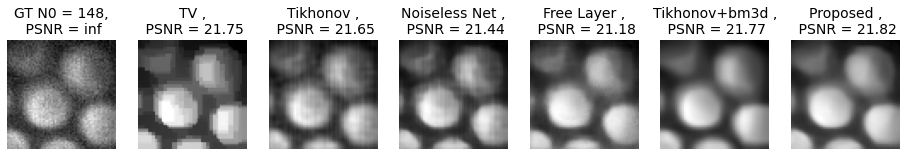

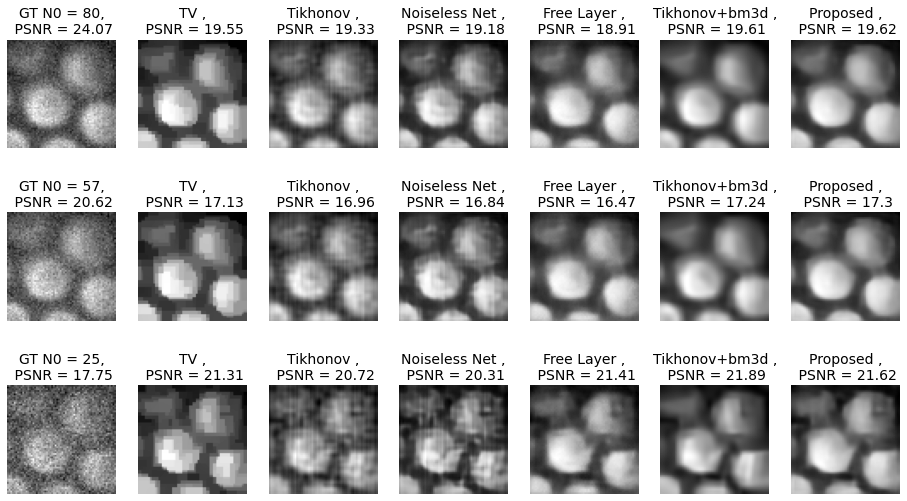

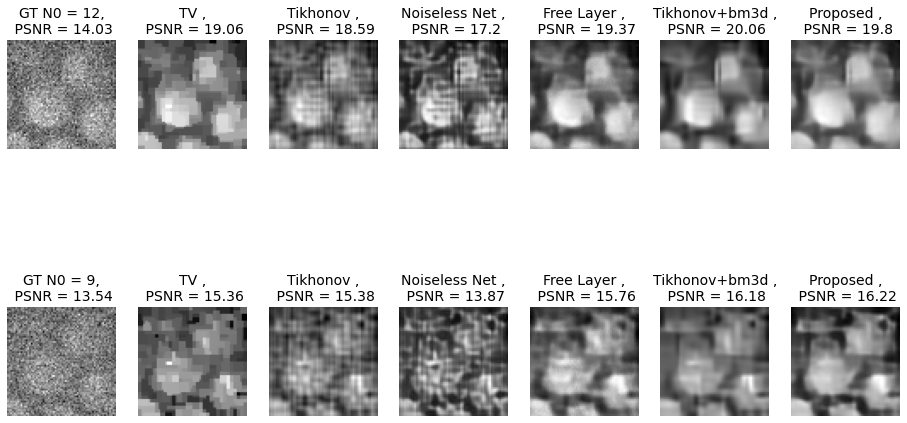

In [17]:
o1 = outputs;
t1 = title_lists;
nb_disp_frames = 7;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

## STL-10 Cat 
### Loading the Compressed Data

In [18]:
titles_expe = ["stl10_05_1.5_0.0_0{}_variance".format(i) for i in range(1,7)]+\
              ["stl10_05_1_0.3_variance", "stl10_05_1_0.6_variance"]

expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];
nflip = [1.5 for i in range(len(titles_expe))];
nflip[-2:] = [1 for i in range(len(nflip[-2:]))]
channel = 581;
m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);


m_prim = [];
m_prim = [];
m_prim.append(sum(m_list[:7]));
m_prim.append(m_list[0]+m_list[1]);
m_prim.append(m_list[2]);
m_prim = m_prim+m_list[-2:];
m_list = m_prim;


### Loading Ground Truth
We normalize the incoming data, so that it has the right functioning range for neural networks to work with.

In [19]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:7]));
GT_prim.append(GT[0]+GT[1]);
GT_prim.append(GT[2]);
GT_prim = GT_prim+GT[-2:];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];


### Displaying the results
Once all the networks have been loaded, we appy those networks on the loaded Compressed Data.

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]


title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

with torch.no_grad():
    for i in range(len(GT)):
        list_outs = [];
        x_Pinv = model_list[0].forward_N0_Pinv(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Stat_comp = model_list[0].forward_N0_maptoimage(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Denoi_Stat_comp = model_list_denoi[0].forward_N0_maptoimage_expe(m_list[i]*4, 1, 1, img_size, img_size, C, s, K);
        x_SDCAN = model_list_no_noise[0].forward_postprocess(x_Stat_comp, 1,1, img_size, img_size);
        x_SDCAN_denoi = model_list_denoi[0].forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);
        x_free = model.forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);

            
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(H_k), np.linalg.inv(np.dot(H_k, np.transpose(H_k)))),m))
        x_tv = 2*TV(m/alpha_est, H_k, img_size)-1;
#         x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),1/alpha_est**2*(1/K*np.mean(torch2numpy(m_list[i][0,0,even_index]+m_list[i][0,0,uneven_index]))- 2*C/K +2*s**2/K**2))
        x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),0.3)

#         print(np.amax(x_tv))
#         print(np.amin(x_tv))

        x_bm3d = torch.Tensor(x_bm3d).to(device);
        x_bm3d = x_bm3d.view(1,1, img_size, img_size);
        x_tv = torch.Tensor(x_tv).to(device);
        x_tv = x_tv.view(1,1, img_size, img_size);
        
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
#         list_outs.append(x_Pinv);
        list_outs.append(x_tv);
        list_outs.append(x_Denoi_Stat_comp);
        list_outs.append(x_SDCAN);
        list_outs.append(x_free);
        list_outs.append(x_bm3d);
        list_outs.append(x_SDCAN_denoi);
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
#         ssim = batch_ssim_vid(Ground_truth, output);
        output = torch2numpy(output);
        output = batch_flipud(output);
        outputs.append(output);
#         title_lists.append(["{} {},\n PSNR = {},\n SSIM = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2),round( ssim[j],2)) for j in range(len(titles))]);
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);
    



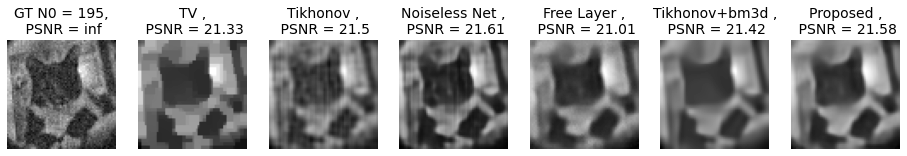

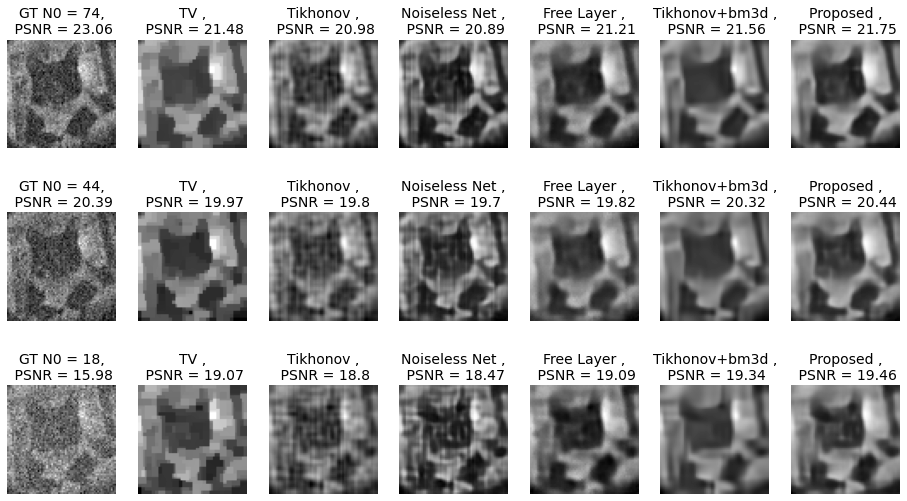

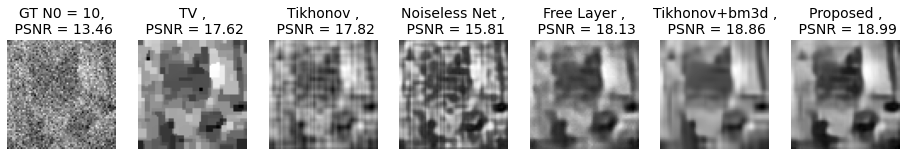

In [21]:
o2 = outputs;
t2 = title_lists;
nb_disp_frames = 7;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

# Compressed Reconstruction via CNN (CR = 3/4)

## Parameters

In [22]:
# num_epochs = 100 ; #Number of training epochs 
num_epochs = 20 ; #Number of training epochs 
batch_size = 256 ; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 10; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate


CR = 1024; # Number of patterns
# CR = 2048; # Number of patterns

even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);


# Var = Cov2Var(Cov_had)
# Perm = Permutation_Matrix(Var)
Pmat = np.dot(Perm,H);
H_k = Pmat[:CR,:];

## Loading Relevant Neural Networks

In [23]:
suffix = '_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(\
        img_size, CR, num_epochs, lr, step_size,\
        gamma, batch_size, reg)

# N0_list = [700, 150, 80, 60, 30, 10, 10];
# N0_list_OG = [500, 150, 80, 60, 30, 10, 2];
N0_list = [2500];
# N0_list = [50];

# with HiddenPrints():
model_list = net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, 0, H, suffix, model_root);
model_list_denoi = net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, 1, H, suffix, model_root);
model_list_no_noise = net_list(img_size, CR, Mean_had, Cov_had,net_arch, [0 for i in range(len(N0_list))], sig, 1, H, suffix,model_root);

model = noiCompNet(img_size, CR, Mean_had, Cov_had, 3, 50, 0.5, H)
root_model = '../../models/OE/NET_free_N0_2500_sig_0.5_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07'
load_net(root_model,model);
model = model.to(device)
titles = ["GT",  "TV", "Tikhonov","Noiseless Net", "Free Layer", "Tikhonov+bm3d", "Proposed"]

# titles = ["GT", "PI",  "TV", "Tikhonov","Noiseless Net", "Free Layer", "Tikhonov+bm3d", "Proposed"]


Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Model Loaded: ../../models/SDCAN/NET_c0mp_N0_2500_sig_0.5_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
Varying N0 = 2500 +/- 1250
Denoised Measurements
Model Loaded: ../../models/SDCAN/NET_c0mp_N0_2500_sig_0.5_Denoi_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: statistical completion (no mean)
Model Loaded: ../../models/SDCAN/NET_c0mp_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07
Measurement to image domain: free
Varying N0 = 50 +/- 25
Model Loaded: ../../models/OE/NET_free_N0_2500_sig_0.5_N_64_M_1024_epo_20_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


## Siemens Star
### Loading the Compressed Data

In [24]:
titles_expe = ["starSectorD_2_0.0_01_variance", "starSectorD_2_0.0_02_variance"]+\
              ["starSectorD_2_0.0_03_variance", "starSectorD_2_0.0_04_variance"]+\
              ["starSectorD_2_0.0_05_variance", "starSectorD_2_0.0_06_variance"]+\
              ["starSectorD_2_0.0_07_variance", "starSectorD_2_0.0_08_variance"]+\
              ["starSectorD_2_0.0_09_variance", "starSectorD_2_0.0_variance"]+\
              ["starSectorD_2_0.3_variance", "starSectorD_2_0.6_variance"]+\
              ["starSectorD_2_1.0_variance", "starSectorD_2_1.3_variance"]

channel = 510;

nflip = [2 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);
    
m_prim = [];
m_prim.append(sum(m_list[:10]));
m_prim.append(sum(m_list[7:9]));
m_prim = m_prim+m_list[9:];
m_list = m_prim;

### Loading Ground Truth
We normalize the incoming data, so that it has the right functioning range for neural networks to work with.

In [25]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600 -510

GT_prim = [];
GT_prim.append(sum(GT[:10]));
GT_prim.append(sum(GT[7:9]));
GT_prim = GT_prim+GT[9:];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];


### Displaying the results
Once all the networks have been loaded, we appy those networks on the loaded Compressed Data.

In [26]:
m_list[0].shape

torch.Size([1, 1, 2048])

In [27]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]


title_lists = [];
Additional_info = [["N0 = {}".format(round(max_list[i])) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];

with torch.no_grad():
    for i in range(len(GT)):
        list_outs = [];
        x_Pinv = model_list[0].forward_N0_Pinv(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Stat_comp = model_list[0].forward_N0_maptoimage(1/K*m_list[i]*4, 1, 1, img_size, img_size);
        x_Denoi_Stat_comp = model_list_denoi[0].forward_N0_maptoimage_expe(m_list[i]*4, 1, 1, img_size, img_size, C, s, K);
        x_SDCAN = model_list_no_noise[0].forward_postprocess(x_Stat_comp, 1,1, img_size, img_size);
        x_SDCAN_denoi = model_list_denoi[0].forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);
        x_free = model.forward_N0_reconstruct_expe(m_list[i]*4,1,1, img_size, img_size, C, s, K);

        
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(H_k), np.linalg.inv(np.dot(H_k, np.transpose(H_k)))),m))
        x_tv = 2*TV(m/alpha_est, H_k, img_size)-1;
#         x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),1/alpha_est**2*(1/K*np.mean(torch2numpy(m_list[i][0,0,even_index]+m_list[i][0,0,uneven_index]))- 2*C/K +2*s**2/K**2))

        x_bm3d = bm3d(torch2numpy(x_Denoi_Stat_comp[0,0,:,:]),0.3)

        
#         print(np.amax(x_tv))
#         print(np.amin(x_tv))

        x_bm3d = torch.Tensor(x_bm3d).to(device);
        x_bm3d = x_bm3d.view(1,1, img_size, img_size);
        x_tv = torch.Tensor(x_tv).to(device);
        x_tv = x_tv.view(1,1, img_size, img_size);
        
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
#         list_outs.append(x_Pinv);
        list_outs.append(x_tv);
        list_outs.append(x_Denoi_Stat_comp);
        list_outs.append(x_SDCAN);
        list_outs.append(x_free);
        list_outs.append(x_bm3d);
        list_outs.append(x_SDCAN_denoi);
        output = torch.stack(list_outs, axis = 1);

        psnr = batch_psnr_vid(Ground_truth, output);
#         ssim = batch_ssim_vid(Ground_truth, output);
        outputs.append(torch2numpy(output));
#         title_lists.append(["{} {},\n PSNR = {},\n SSIM = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2),round( ssim[j],2)) for j in range(len(titles))]);
        title_lists.append(["{} {},\n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr[j],2)) for j in range(len(titles))]);
    



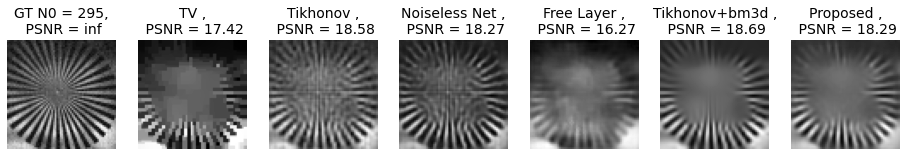

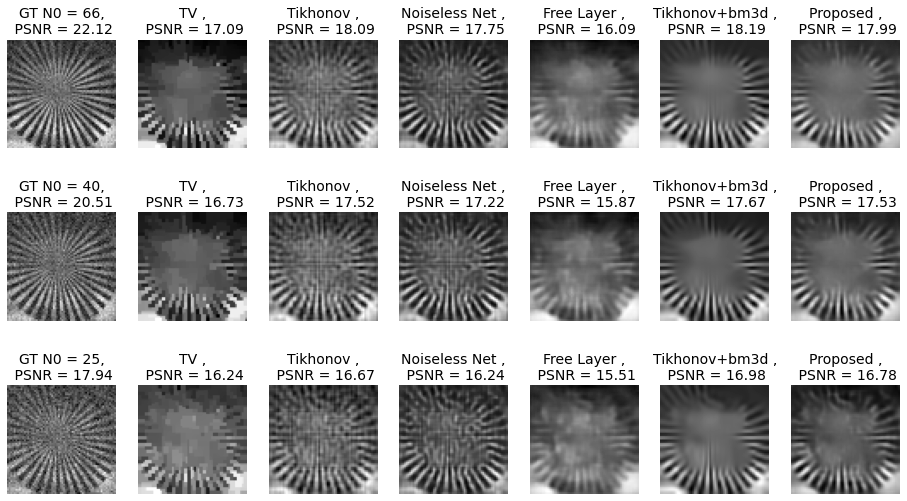

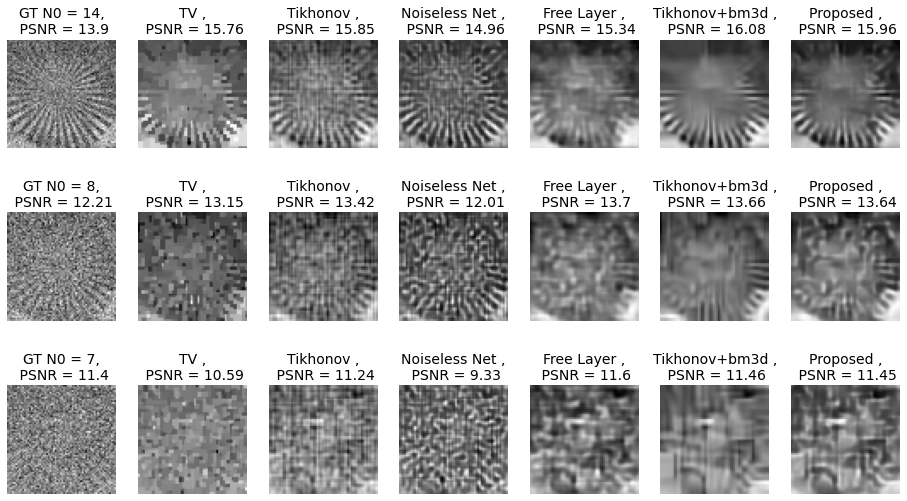

In [28]:
o3 = outputs;
t3 = title_lists;
nb_disp_frames = 7;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

# Final Figure

In [29]:
out_lamp = np.concatenate((np.reshape(o1[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o1[-1]), axis = 1)
title_lamp = [t1[0][0][:-11] + "(a)"]+t1[-1]

out_cat = np.concatenate((np.reshape(o2[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o2[-1]), axis = 1)
title_cat = [t2[0][0][:-11] + "(b)"]+t2[-1]

out_star = np.concatenate((np.reshape(o3[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o3[-4]), axis = 1)
title_star = [t3[0][0][:-11] + "(c)"]+t3[-4]

outputs = [out_lamp, out_cat, out_star]
title_lists = [title_lamp, title_cat, title_star]

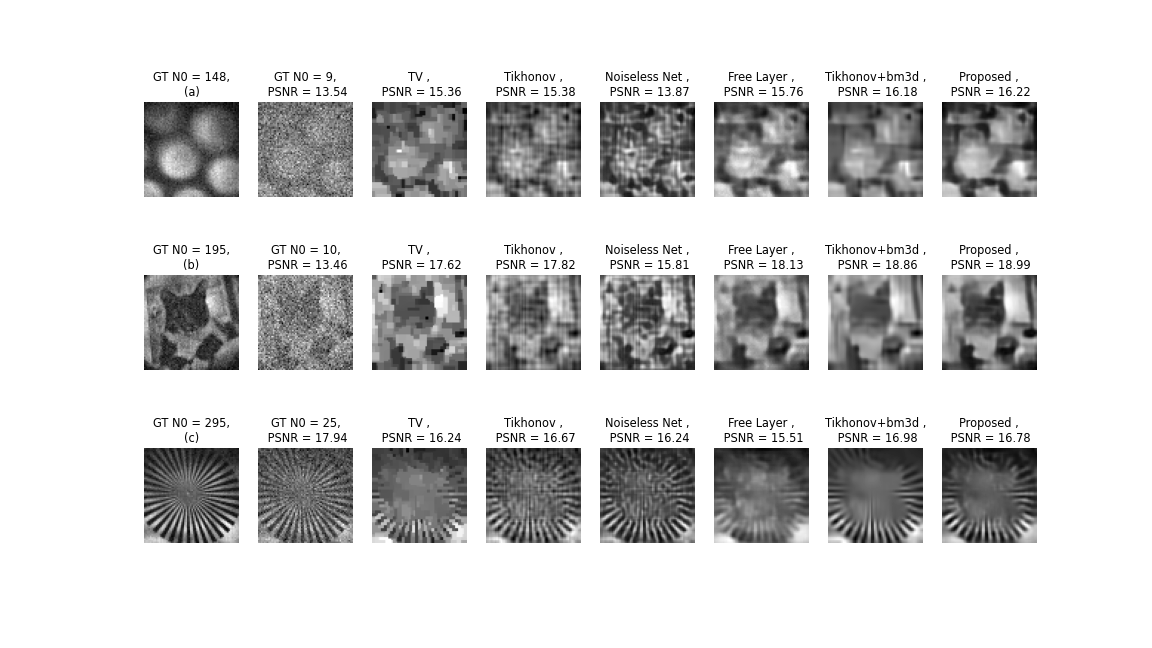

In [30]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['pdf.fonttype'] = 42
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['pdf.fonttype'] = 42
nb_disp_frames = 8
compare_video_frames(outputs, nb_disp_frames, title_lists, savefig = '../../img/tci/results_expe.pdf', fontsize = 11.4)

In [31]:
def transpose(liste):
    x = len(liste);
    y = len(liste[0]);
    out = [];
    for i in range(y):
        out_i = [];
        for j in range(x):
            out_i.append(liste[j][i]);
        out.append(out_i);
    return out;

def transpose_vid(liste):
    x = len(liste);
    y = liste[0].shape[1];
    n = liste[0].shape[-1]
    out = [];
    for i in range(y):
        out_i = np.zeros((1,x,1,n,n));
        for j in range(x):
            out_i[0,j,0,:,:] = liste[j][0,i,0,:,:];
        out.append(out_i);
    return out;

In [32]:
# compare_video_frames(transpose_vid(outputs), 3, transpose(title_lists), aspect = (9,30), savefig = '../../img/tci/results_expe.pdf', fontsize = 11.4)

In [ ]:
# type(outputs[0])

In [ ]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['pdf.fonttype'] = 42
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [30, 20]
plt.rcParams['pdf.fonttype'] = 42
nb_disp_frames = 4

title_lists[0][1] = "Noisy "+ title_lists[0][1]
title_lists[2][1] = "Noisy "+ title_lists[2][1]
title_lists[1][1] = "Noisy "+ title_lists[1][1]
compare_video_frames([outputs[0][:,:4,:,:,:]], nb_disp_frames, [title_lists[0][:4]], savefig = '../../img/tci/results_expe_1.pdf', fontsize = 11.4)
compare_video_frames([outputs[0][:,4:,:,:,:]], nb_disp_frames, [title_lists[0][4:]], savefig = '../../img/tci/results_expe_2.pdf', fontsize = 11.4)

compare_video_frames([outputs[1][:,:4,:,:,:]], nb_disp_frames, [title_lists[1][:4]], savefig = '../../img/tci/results_expe_3.pdf', fontsize = 11.4)
compare_video_frames([outputs[1][:,4:,:,:,:]], nb_disp_frames, [title_lists[1][4:]], savefig = '../../img/tci/results_expe_4.pdf', fontsize = 11.4)

compare_video_frames([outputs[2][:,:4,:,:,:]], nb_disp_frames, [title_lists[2][:4]], savefig = '../../img/tci/results_expe_5.pdf', fontsize = 11.4)
compare_video_frames([outputs[2][:,4:,:,:,:]], nb_disp_frames, [title_lists[2][4:]], savefig = '../../img/tci/results_expe_6.pdf', fontsize = 11.4)